In [18]:
# Load libriaries and functions.
import scipy
import pandas as pd
import numpy as np
import collections
import tensorflow as tf
tfk = tf.keras
tf.keras.backend.set_floatx("float64")
import tensorflow_probability as tfp
tfd = tfp.distributions
# Define helper functions.
neg_log_likelihood = lambda x, rv_x: -rv_x.log_prob(x)

In [2]:
#Training and testing on C2+C3
NS_case1 = pd.read_excel("NS_EOS_Case1.xlsx")
NS_case2 = pd.read_excel("NS_EOS_Case2.xlsx")
NS_case3 = pd.read_excel("NS_EOS_Case3.xlsx")
NS = pd.concat([NS_case2,NS_case3],ignore_index=True)
X = NS.iloc[:, 0:7].values
y = NS.iloc[:, [7,9,11]].values

In [3]:
columns = NS_case2.columns[0:8].tolist() + [NS_case2.columns[9]]+ [NS_case2.columns[11]]
inputs = columns[0:7]
outputs = columns[7:]

## Preprocessing


In [4]:
#Standardizing the data
from sklearn.preprocessing import StandardScaler
sc_X = StandardScaler()
X = sc_X.fit_transform(X)
sc_y = StandardScaler()
y = sc_y.fit_transform(y)
X_t = np.hstack((X,y))
# Restore frame.
dataset = pd.DataFrame(X_t, columns=columns)

In [5]:

dataset

,e(0),rho(0),K(0),Q(0),J(0),L(0),Ksym(0),NS mass,R14,Lambda14
0,-0.414747,-2.563707,1.940126,0.830094,-1.301915,-0.082711,-0.850796,-2.333596,0.448521,0.008563
1,-1.390824,-0.085593,3.117088,0.293295,-1.070268,-0.197467,-1.114236,-2.365787,-0.054689,-0.383045
2,-0.285088,1.138167,-1.950281,2.532391,1.407779,1.621897,2.924565,-1.288461,-4.280704,-3.131814
3,3.793110,-1.095195,-1.768451,1.625406,-0.861081,2.819353,2.861728,-0.945090,2.558167,2.885653
4,-1.289642,1.168761,-2.358041,2.524679,-0.482247,1.608749,2.443426,-1.749865,0.672108,0.974248
...,...,...,...,...,...,...,...,...,...,...
4780,0.013006,0.342723,-0.034059,0.043226,0.977048,-1.787312,-1.408961,-0.731556,-1.758908,-1.440686
4781,0.013612,-0.116187,-0.033987,0.043232,1.536141,-1.361960,-1.027163,0.176230,-1.128634,-0.949154
4782,0.011189,-0.177375,-0.033908,0.043193,1.493111,-1.790466,-1.500397,-0.584551,-1.681437,-1.397515
4783,0.014218,0.006189,-0.033948,0.043213,1.987805,-1.475961,-1.207794,0.033517,-1.293943,-1.093398


In [48]:
# Define some hyperparameters.
n_epochs = 40
n_samples = dataset.shape[0]
n_batches = 32
batch_size = np.floor(n_samples/n_batches)
buffer_size = n_samples

# Define training and test data sizes.
n_train = int(0.7*dataset.shape[0])

# Define dataset instance.
data = tf.data.Dataset.from_tensor_slices((dataset[inputs].values, dataset[outputs].values))
data = data.shuffle(n_samples, reshuffle_each_iteration=True)

# Define train and test data instances.
data_train = data.take(n_train).batch(batch_size).repeat(n_epochs)
data_test = data.skip(n_train).batch(1).repeat(n_epochs)

## Model Building
### Aleotoric Uncertainty
To account for aleotoric uncertainty, which arises from the noise in the output, dense layers are combined with probabilistic layers. More specifically, the mean and covariance matrix of the output is modelled as a function of the input and parameter weights. The first hidden layer shall consist of 10 nodes, the second one needs 3 nodes for the means plus ten nodes for the variances and covariances of the 3-dimensional (there are 3 outputs) multivariate Gaussian posterior probability distribution in the final layer. This is achieved using the params_size method of the last layer (MultivariateNormalTriL), which is the declaration of the posterior probability distribution structure, in this case a multivariate normal distribution in which only one half of the covariance matrix is estimated (due to symmetry). The total number of parameters in the model is 179 — estimated by variational methods. The deterministic version of this neural network consists of an input layer, ten latent variables (hidden nodes), and an output layer (114 parameters), which does not include the uncertainty in the parameters weights.

In [49]:
class EarlyStoppingAtMinLoss(tfk.callbacks.Callback):
    """Stop training before loss becomes negative

  Arguments:
      patience: Number of epochs to wait after min has been hit. After this
      number of no improvement, training stops.
  """

    def __init__(self, patience=0):
        super(EarlyStoppingAtMinLoss, self).__init__()
        self.patience = patience
        # best_weights to store the weights at which the minimum loss occurs.
        self.best_weights = None

    def on_train_begin(self, logs=None):
        # The number of epoch it has waited when loss is no longer minimum.
        self.wait = 0
        # The epoch the training stops at.
        self.stopped_epoch = 0
        # Initialize the best as infinity.
        self.best = np.Inf

    def on_epoch_end(self, epoch, logs=None):
        current = logs.get("loss")
        if np.less(current, self.best) and current>0:
            self.best = current
            self.wait = 0
            # Record the best weights if current results is better (less).
            self.best_weights = self.model.get_weights()
        elif np.less(current,0):
            '''self.wait += 1
            if self.wait >= self.patience:'''
            self.stopped_epoch = epoch
            self.model.stop_training = True
            print("\n Restoring model weights from the end of the best epoch.")
            self.model.set_weights(self.best_weights)
        

    def on_train_end(self, logs=None):
        if self.stopped_epoch > 0:
            print("Epoch %02d: early stopping" % (self.stopped_epoch))


In [50]:
# Define prior for regularization.
len_inputs = 7
len_outputs = 3
prior = tfd.Independent(tfd.Normal(loc=tf.zeros(len_outputs, dtype=tf.float64), scale=1.0), reinterpreted_batch_ndims=1)
# Define model instance.
def BNN_Model(no_of_nodes,i):
  model = tfk.Sequential([tfk.layers.InputLayer(input_shape=(len_inputs,), name="input"),
                          tfk.layers.Dense(no_of_nodes, activation="relu", name="dense_1"),
                          tfk.layers.Dense(tfp.layers.MultivariateNormalTriL.params_size(len_outputs), activation=None, 
                                          name="distribution_weights"),
                        
                          tfp.layers.MultivariateNormalTriL(len_outputs, 
                                                            activity_regularizer=
                                                            tfp.layers.KLDivergenceRegularizer(prior,weight=1/n_batches)
                                    , name="output")]
                        , name="BNN-"+str(i))
  # Compile model.
  model.compile(optimizer="adam", loss=neg_log_likelihood)
  # Run training session.
  model.fit(data_train, epochs=n_epochs, validation_data=data_test, verbose=True,callbacks=[EarlyStoppingAtMinLoss()])
  # Describe model.
  return model

In [51]:
models = []
for i in range(1,21):
  model_i = BNN_Model(i,i)
  print("model "+str(i)+" trained.")
  models.append(model_i)

Epoch 1/40
920/920 [==============================] - 42s 46ms/step - loss: 22.8321 - val_loss: 7.6440
Epoch 2/40
920/920 [==============================] - 42s 46ms/step - loss: 5.9532 - val_loss: 4.9159
Epoch 3/40
920/920 [==============================] - 42s 46ms/step - loss: 4.4737 - val_loss: 4.1669
Epoch 4/40
920/920 [==============================] - 42s 45ms/step - loss: 3.9634 - val_loss: 3.8107
Epoch 5/40
920/920 [==============================] - 42s 45ms/step - loss: 3.7082 - val_loss: 3.6347
Epoch 6/40
920/920 [==============================] - 42s 46ms/step - loss: 3.5555 - val_loss: 3.5035
Epoch 7/40
920/920 [==============================] - 42s 46ms/step - loss: 3.4330 - val_loss: 3.3632
Epoch 8/40
920/920 [==============================] - 42s 45ms/step - loss: 3.3048 - val_loss: 3.2318
Epoch 9/40
920/920 [==============================] - 45s 49ms/step - loss: 3.1572 - val_loss: 3.0829
Epoch 10/40
920/920 [==============================] - 43s 46ms/step - loss: 3.01

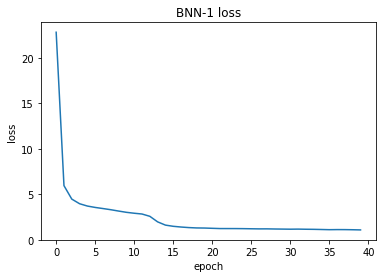

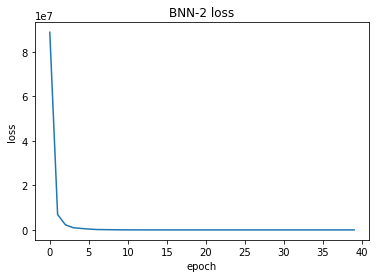

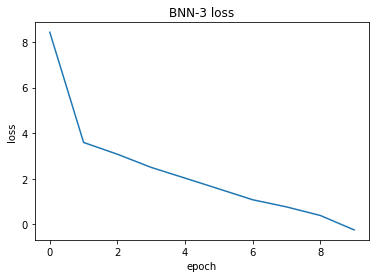

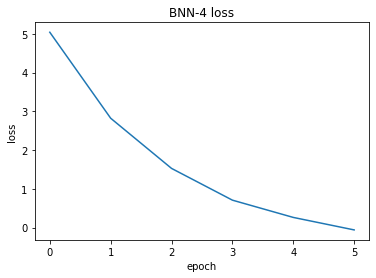

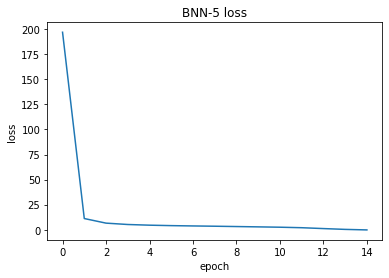

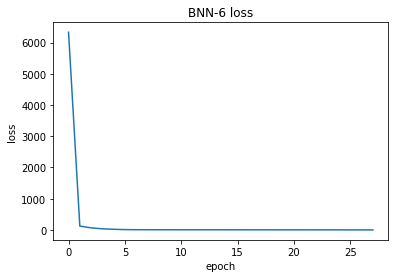

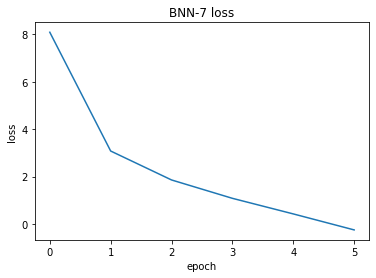

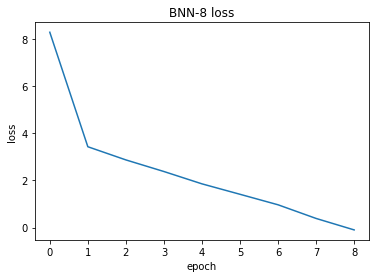

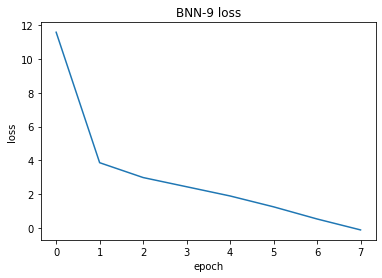

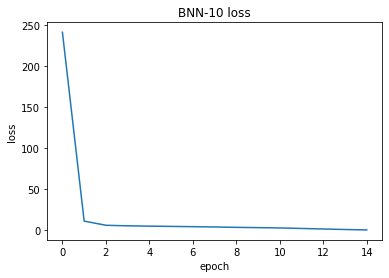

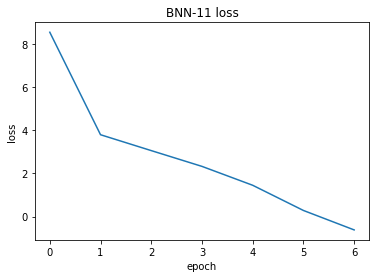

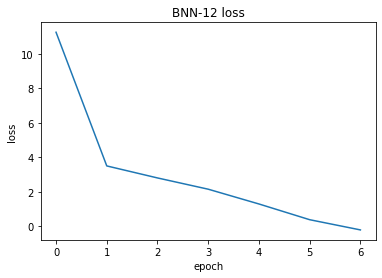

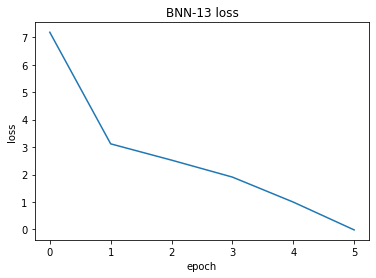

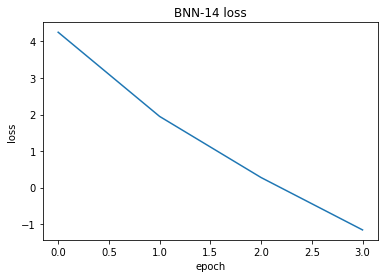

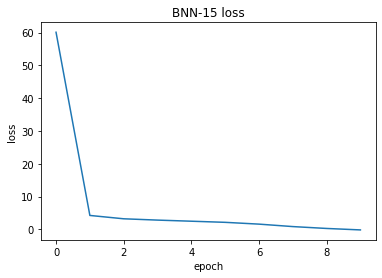

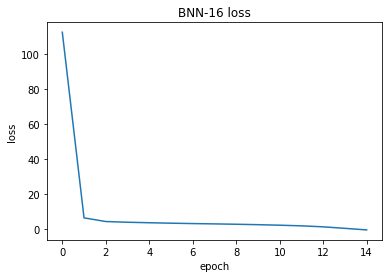

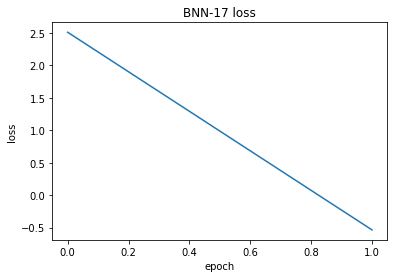

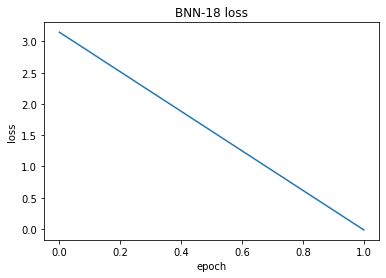

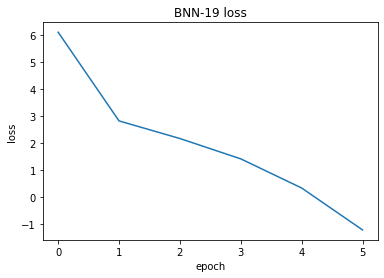

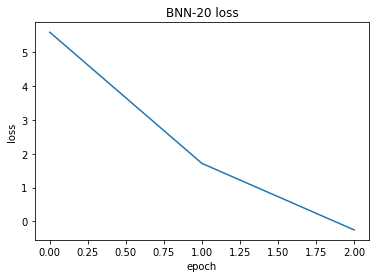

In [52]:
import matplotlib.pyplot as plt
# "Loss"
for model in models:
  plt.plot(model.history.history['loss'])
  plt.title(model.name+' loss')
  plt.ylabel('loss')
  plt.xlabel('epoch')
  plt.show()

The activity_regularizer argument acts as prior for the output layer (the weight has to be adjusted to the number of batches). The training session might take a while depending on the specifications of your machine.

## Aleotoric and Epistemic Uncertainty
To account for aleotoric and epistemic uncertainty (uncertainty in parameter weights), the dense layers have to be exchanged with Flipout layers (DenseFlipout). Such a model has 424 parameters, since every weight is parametrized by normal distribution with non-shared mean and standard deviation, hence doubling the amount of parameter weights. Weights will be resampled for different predictions, and in that case, the Bayesian neural network will act like an ensemble.

tfp.layers.DenseFlipout(10, activation="relu", name="dense_1")

The default prior distribution over weights is tfd.Normal(loc=0., scale=1.) and can be adjusted using the kernel_prior_fn argument.

## Prediction
Since it is a probabilistic model, a Monte Carlo experiment is performed to provide a prediction. In particular, every prediction of a sample x results in a different output y, which is why the expectation over many individual predictions has to be calculated. Additionally, the variance can be determined this way.

In [53]:
# Predict.
import sklearn.metrics
def prediction(model,result_new):
  samples = 100
  iterations = 10
  test_iterator = tf.compat.v1.data.make_one_shot_iterator(data_test)
  X_true = np.empty(shape=(samples, len_inputs))
  Y_true = np.empty(shape=(samples, len_outputs))
  Y_pred = np.empty(shape=(samples, len_outputs, iterations))

  for i in range(samples):
      features, labels = test_iterator.get_next()
      X_true[i,:] = features
      X_true[i,:] = sc_X.inverse_transform(X_true[i,:])
      Y_true[i,:] = labels.numpy()
      Y_true[i,:] = sc_y.inverse_transform(Y_true[i,:])
      for k in range(iterations):
          Y_pred[i,:,k] = model.predict(features)
          Y_pred[i,:,k] = sc_y.inverse_transform(Y_pred[i,:,k])

  # Calculate mean and standard deviation.
  Y_pred_m = np.mean(Y_pred, axis=-1)
  Y_pred_s = np.std(Y_pred, axis=-1)

  #RMS value
  rms = sklearn.metrics.mean_squared_error(Y_true, Y_pred_m)**0.5
  rms_mass = sklearn.metrics.mean_squared_error(Y_true[:,0], Y_pred_m[:,0])**0.5
  rms_rad = sklearn.metrics.mean_squared_error(Y_true[:,1], Y_pred_m[:,1])**0.5
  rms_lam = sklearn.metrics.mean_squared_error(Y_true[:,2], Y_pred_m[:,2])**0.5

  #R2 value
  r2 = sklearn.metrics.r2_score(Y_true,Y_pred_m)

  #for sigma_1 and sigma_2
  sig_1_minus = Y_pred_m - Y_pred_s
  sig_1_plus = Y_pred_m + Y_pred_s
  sig_2_minus = Y_pred_m - 2*Y_pred_s
  sig_2_plus = Y_pred_m + 2*Y_pred_s
  sig_1_NSM = collections.Counter([sig_1_minus[i,0]<=Y_true[i,0]<=sig_1_plus[i,0] for i in range(samples)])[True]
  sig_1_NSR = collections.Counter([sig_1_minus[i,1]<=Y_true[i,1]<=sig_1_plus[i,1] for i in range(samples)])[True]
  sig_1_NSL = collections.Counter([sig_1_minus[i,2]<=Y_true[i,2]<=sig_1_plus[i,2] for i in range(samples)])[True]
  sig_2_NSM = collections.Counter([sig_2_minus[i,0]<=Y_true[i,0]<=sig_2_plus[i,0] for i in range(samples)])[True]
  sig_2_NSR = collections.Counter([sig_2_minus[i,1]<=Y_true[i,1]<=sig_2_plus[i,1] for i in range(samples)])[True]
  sig_2_NSL = collections.Counter([sig_2_minus[i,2]<=Y_true[i,2]<=sig_2_plus[i,2] for i in range(samples)])[True]

  #For PC
  PC_pred = scipy.stats.pearsonr(Y_pred_m[:,2],X_true[:,6])
  PC_true = scipy.stats.pearsonr(Y_true[:,2],X_true[:,6])

  result_new = result_new.append({'Model': model.name, 'RMS':rms,'RMS_NS_Mass':rms_mass,'RMS_NS_Rad':rms_rad,'RMS_Lam':rms_lam,
                                  'R2':r2,'PC (Lam_1.6 vs Ksym(0) (True,Pred)':(PC_true[0],PC_pred[0]),
                                  'sigma_1_NSM':sig_1_NSM/samples,'sigma_1_NSR':sig_1_NSR/samples,'sigma_1_NSL':sig_1_NSL/samples,
                                  'sigma_2_NSM':sig_2_NSM/samples,'sigma_2_NSR':sig_2_NSR/samples,'sigma_2_NSL':sig_2_NSL/samples}, ignore_index=True)
  return result_new


In [54]:
result_new = pd.DataFrame(columns=['Model','RMS','RMS_NS_Mass','RMS_NS_Rad','RMS_Lam','R2','PC (Lam_1.6 vs Ksym(0) (True,Pred)',
                                   'sigma_1_NSM','sigma_1_NSR','sigma_1_NSL','sigma_2_NSM','sigma_2_NSR','sigma_2_NSL'])

In [55]:
for model in models:
  result_new = prediction(model,result_new)
result_new

,Model,RMS,RMS_NS_Mass,RMS_NS_Rad,RMS_Lam,R2,"PC (Lam_1.6 vs Ksym(0) (True,Pred)",sigma_1_NSM,sigma_1_NSR,sigma_1_NSL,sigma_2_NSM,sigma_2_NSR,sigma_2_NSL
0,BNN-1,36.727876,0.056537,0.617478,63.611525,0.590551,"(0.9195981560996895, 0.9318848239993133)",0.70,0.56,0.56,0.92,0.86,0.86
1,BNN-2,72.825824,0.096429,0.629132,126.136422,-0.026909,"(0.9063816124124513, 0.27690598087947804)",0.54,0.60,0.58,0.82,0.87,0.90
2,BNN-3,21.376955,0.068223,0.230889,37.025190,0.802211,"(0.9121065658260482, 0.9143373371075455)",0.58,0.75,0.63,0.88,0.90,0.85
3,BNN-4,11.349398,0.057503,0.242181,19.656158,0.796596,"(0.9206310342258318, 0.9390435686794307)",0.67,0.72,0.78,0.91,0.96,0.96
4,BNN-5,19.335376,0.063482,0.254327,33.488827,0.796861,"(0.8963014869220749, 0.8837079659048124)",0.71,0.84,0.72,0.91,0.92,0.92
5,BNN-6,14.160746,0.065759,0.173254,24.526431,0.825604,"(0.9009473055051844, 0.9241367605899089)",0.64,0.78,0.75,0.87,0.96,0.94
6,BNN-7,17.461009,0.068116,0.305982,30.241730,0.768195,"(0.904185925844418, 0.9293933679250419)",0.77,0.76,0.71,0.94,0.96,0.89
7,BNN-8,17.611789,0.073204,0.166191,30.503972,0.720390,"(0.9019621847142475, 0.914345223398708)",0.64,0.73,0.69,0.95,0.95,0.93
8,BNN-9,11.155777,0.048876,0.171477,19.321549,0.869391,"(0.9221330934281355, 0.9435917502288576)",0.73,0.80,0.88,0.91,0.97,0.98
9,BNN-10,11.247332,0.059860,0.141286,19.480346,0.827740,"(0.9475239062621026, 0.949240821290719)",0.78,0.88,0.84,0.95,0.98,0.97


In [56]:
result_new.to_excel("BNN_Models.xlsx",index = False)

In [57]:
result_new = pd.read_excel("BNN_Models.xlsx")

In [68]:
result_new_b = result_new[result_new['RMS']<15]
result_new_better = result_new_b[result_new_b['R2']>0.8]
result_new_better = result_new_better.sort_values(['RMS'],inplace=False)
result_new_better.reset_index(inplace = True)
result_new_better = result_new_better.drop(columns=['index'])
result_new_better

,Model,RMS,RMS_NS_Mass,RMS_NS_Rad,RMS_Lam,R2,"PC (Lam_1.6 vs Ksym(0) (True,Pred)",sigma_1_NSM,sigma_1_NSR,sigma_1_NSL,sigma_2_NSM,sigma_2_NSR,sigma_2_NSL
0,BNN-19,9.859321,0.058202,0.130934,17.076243,0.847003,"(0.9324865231299561, 0.9281179906486872)",0.72,0.79,0.88,0.94,0.97,0.98
1,BNN-9,11.155777,0.048876,0.171477,19.321549,0.869391,"(0.9221330934281355, 0.9435917502288576)",0.73,0.80,0.88,0.91,0.97,0.98
2,BNN-16,11.228783,0.058024,0.203776,19.447669,0.810475,"(0.9090184922830656, 0.9201969013429318)",0.71,0.87,0.74,0.94,0.98,0.90
3,BNN-10,11.247332,0.059860,0.141286,19.480346,0.827740,"(0.9475239062621026, 0.949240821290719)",0.78,0.88,0.84,0.95,0.98,0.97
4,BNN-20,13.406316,0.056145,0.229794,23.219215,0.811083,"(0.897188193033213, 0.9025781686115184)",0.78,0.94,0.84,0.95,0.98,1.00
5,BNN-6,14.160746,0.065759,0.173254,24.526431,0.825604,"(0.9009473055051844, 0.9241367605899089)",0.64,0.78,0.75,0.87,0.96,0.94


In [69]:
result_new_better.to_excel("BNN_Best_Models.xlsx",index = False)

In [70]:
best_models_list = [19,9,16,10,20,6]

In [60]:
#Selecting model to show output (best overall is 18)
model_i = models[18]
samples = 100
iterations = 10
test_iterator = tf.compat.v1.data.make_one_shot_iterator(data_test)
X_true = np.empty(shape=(samples, len_inputs))
Y_true = np.empty(shape=(samples, len_outputs))
Y_pred = np.empty(shape=(samples, len_outputs, iterations))

for i in range(samples):
    features, labels = test_iterator.get_next()
    X_true[i,:] = features
    X_true[i,:] = sc_X.inverse_transform(X_true[i,:])
    Y_true[i,:] = labels.numpy()
    Y_true[i,:] = sc_y.inverse_transform(Y_true[i,:])
    for k in range(iterations):
        Y_pred[i,:,k] = model_i.predict(features)
        Y_pred[i,:,k] = sc_y.inverse_transform(Y_pred[i,:,k])

# Calculate mean and standard deviation.
Y_pred_m = np.mean(Y_pred, axis=-1)
Y_pred_s = np.std(Y_pred, axis=-1)

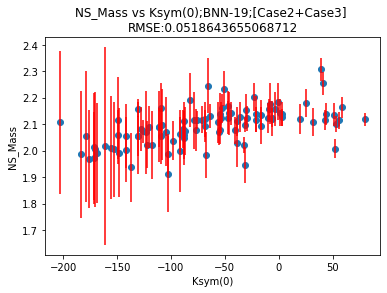

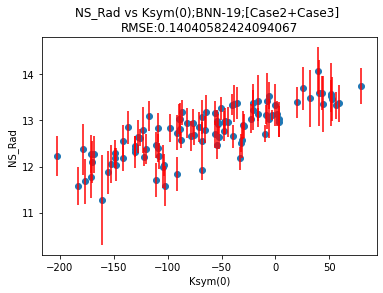

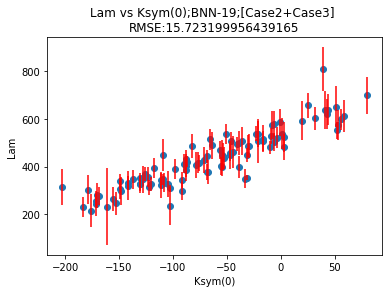

In [61]:
#plot of values and error bars
import sklearn.metrics
import matplotlib.pyplot as plt
titles = ['NS_Mass','NS_Rad','Lam']
for i in range(3):
    rms = 'RMSE:'+str((np.sqrt(sklearn.metrics.mean_squared_error(Y_true[:,i], Y_pred_m[:,i]))))
    fig, ax = plt.subplots()
    ax.scatter(X_true[:,6],Y_pred_m[:,i])
    ax.errorbar(X_true[:,6],Y_pred_m[:,i],yerr=2*Y_pred_s[:,i],ecolor='red',linestyle="None")
    ax.set_ylabel(titles[i])
    ax.set_xlabel('Ksym(0)')
    plt.title(titles[i]+' vs Ksym(0);'+model_i.name+';[Case2+Case3] \n'+rms)
    plt.show()

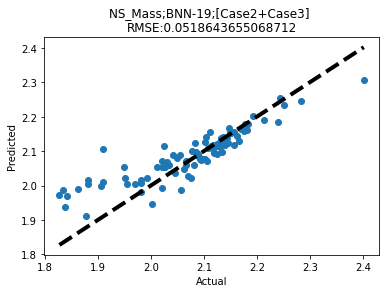

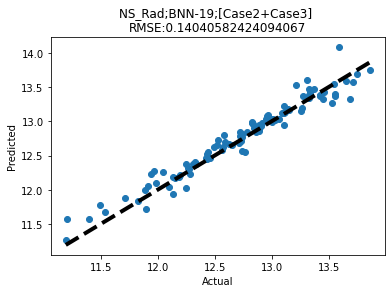

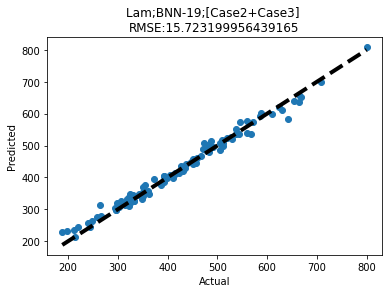

In [62]:
#Plotting
titles = ['NS_Mass','NS_Rad','Lam']
for i in range(3):
    rms = 'RMSE:'+str((np.sqrt(sklearn.metrics.mean_squared_error(Y_true[:,i], Y_pred_m[:,i]))))
    fig, ax = plt.subplots()
    ax.scatter(Y_true[:,i], Y_pred_m[:,i])
    ax.plot([Y_true[:,i].min(), Y_true[:,i].max()], [Y_true[:,i].min(), Y_true[:,i].max()], 'k--', lw=4)
    ax.set_xlabel('Actual')
    ax.set_ylabel('Predicted')
    plt.title(titles[i]+';'+model_i.name+';[Case2+Case3] \n'+rms)
    plt.show()